In [1]:
import numpy as np
import os
from pathlib import Path
from keras.preprocessing import image
import matplotlib.pyplot as plt

## Dataset Preparation

In [2]:
img_data=[]
labels=[]

label_dict = {'Bulbasaur':0,'Meowth':1,'Pikachu':2}
label2pok = {0:'Bulbasaur',1:'Meowth',2:'Pikachu'}

p = Path('./Desktop/Machine-Learning-master/33. Project - Pokemon Image Classifier using MLP/Pictures/Dataset')
dirs = p.glob('*')
for folder_dir in dirs:
    label = str(folder_dir).split('\\')[-1]
    count = 0
    for img_path in folder_dir.glob('*.jpg'):
        img=image.load_img(img_path,target_size=(40,40))
        img_array=image.img_to_array(img)
        img_data.append(img_array)
        labels.append(label_dict[label])
        count+=1
    print(count)

173
70
199


## Dataset Visualization

In [3]:
X = np.array(img_data)
Y = np.array(labels)

In [4]:
X.shape,Y.shape

((442, 40, 40, 3), (442,))

In [12]:
def drawImg(img,label):
    plt.title(label2pok[label])
    plt.imshow(img)
    plt.axis('off')
    plt.show()

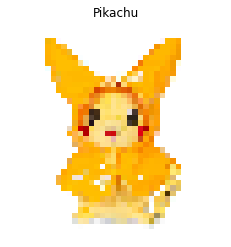

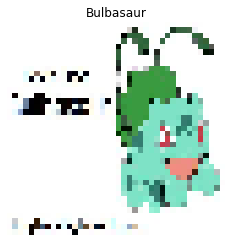

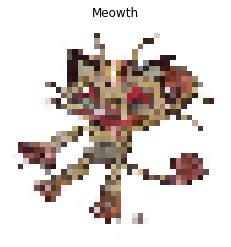

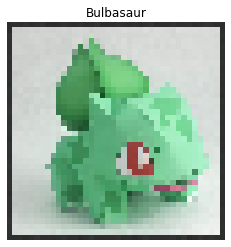

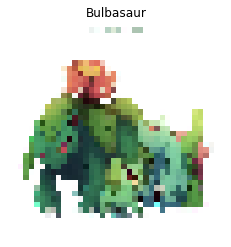

In [13]:
for ix in (np.random.randint(low=1,high=400,size=5)):
    drawImg(X[ix]/255.0,Y[ix])

## Training and Testing Data

In [14]:
split = int(X.shape[0]*.8)

In [15]:
X_train = X[:split,:]
Y_train = Y[:split]
X_test = X[split:,]
Y_test = Y[split:]

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(353, 40, 40, 3) (353,)
(89, 40, 40, 3) (89,)


In [16]:
def softmax(z):
    e_pa = np.exp(z)
    ans = e_pa/np.sum(e_pa,axis=1,keepdims=True)
    return ans

In [55]:
class NeuralNetwork:
    
    def __init__(self,input_size,layers,output_size):
        np.random.seed(0)
        
        model = {}
        
        model['W1'] = np.random.randn(input_size,layers[0])
        model['b1'] = np.zeros((1,layers[0]))
        
        model['W2'] = np.random.randn(layers[0],layers[1])
        model['b2'] = np.zeros((1,layers[1]))
        
        model['W3'] = np.random.randn(layers[1],output_size)
        model['b3'] = np.zeros((1,output_size))
        
        self.model = model
        
    def forward(self,X):
        W1,W2,W3 = self.model['W1'],self.model['W2'],self.model['W3']
        b1,b2,b3 = self.model['b1'],self.model['b2'],self.model['b3']
        
        z1 = np.dot(X,W1)+b1
        a1 = np.tanh(z1)
        
        z2 = np.dot(a1,W2)+b2
        a2 = np.tanh(z2)
        
        z3 = np.dot(a2,W3)+b3
        y_ = softmax(z3)
        
        self.activation_outputs = (a1,a2,y_)
        return y_
    
    def backward(self,X,Y,l_rate=0.001):
        W1,W2,W3 = self.model['W1'],self.model['W2'],self.model['W3']
        b1,b2,b3 = self.model['b1'],self.model['b2'],self.model['b3']
        
        a1,a2,y_ = self.activation_outputs
        m = X.shape[0]
        
        delta3=y_-Y
        dw3=np.dot(a2.T,delta3)
        db3=np.sum(delta3,axis=0)
        
        delta2=(1-np.square(a2))*np.dot(delta3,W3.T)
        dw2=np.dot(a1.T,delta2)
        db2=np.sum(delta2,axis=0)
        
        delta1=(1-np.square(a1))*np.dot(delta2,W2.T)
        dw1=np.dot(X.T,delta1)
        db1=np.sum(delta1,axis=0)
        
        self.model['W1'] -= l_rate*dw1
        self.model['b1'] -= l_rate*db1
        
        self.model['W2'] -= l_rate*dw2
        self.model['b2'] -= l_rate*db2
        
        self.model['W3'] -= l_rate*dw3
        self.model['b3'] -= l_rate*db3
        
    def predict(self,x):
        y_out = self.forward(x)
        return np.argmax(y_out,axis=1)


In [56]:
def losses(y_oht,p):
        l = -np.mean(y_oht*np.log(p))
        return l
    
def one_hot(y,depth):
    m = y.shape[0]
    y_oht = np.zeros((m,depth))
    y_oht[np.arange(m),y] = 1
    return y_oht

In [57]:
def train(X,Y,model,epochs,l_rate,logs=True):
    training_loss = []
    classes = len(np.unique(Y))
    Y_OHT = one_hot(Y,classes)

    for ix in range(epochs):
        Y_ = model.forward(X)
        l = losses(Y_OHT,Y_)
        training_loss.append(l)
        model.backward(X,Y_OHT,l_rate)
        
        if (logs and ix%50==0):
            print('Epoch %d Loss %.4f'%(ix,l))
    return training_loss

In [58]:
model = NeuralNetwork(input_size=4800,layers=[100,50],output_size=3)

In [59]:
X_train = X_train.reshape(X_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)
print(X_train.shape,X_test.shape)

(353, 4800) (89, 4800)


In [60]:
losses = train(X_train,Y_train,model,500,0.002)

Epoch 0 Loss 1.8742
Epoch 50 Loss 0.2083
Epoch 100 Loss 0.0573
Epoch 150 Loss 0.0362
Epoch 200 Loss 0.0242
Epoch 250 Loss 0.0173
Epoch 300 Loss 0.0129
Epoch 350 Loss 0.0088
Epoch 400 Loss 0.0067
Epoch 450 Loss 0.0055


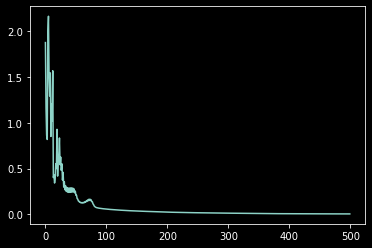

In [61]:
plt.style.use('dark_background')
plt.plot(losses)
plt.show()

In [62]:
def getAccuracy(X,Y):
    Y_ = model.predict(X)
    acc = np.sum(Y_==Y)/Y.shape[0]
    return acc*100

print('Training accuracy %.4f'%getAccuracy(X_train,Y_train))
print('Testing accuracy %.4f'%getAccuracy(X_test,Y_test))

Training accuracy 100.0000
Testing accuracy 58.4270
